### Instalación de librerías

In [1]:
#!pip install pandas --upgrade
#!pip install gensim --upgrade
#!pip install tensorflow --upgrade
#!pip install keras --upgrade
#!pip install python-Levenshtein --upgrade
#!pip install googletrans --upgrade
#!pip install xlsxwriter --upgrade
#python3 -m spacy download es_dep_news_trf
# python -m spacy download es_dep_news_trf

In [2]:
# DataFrame
import pandas as pd
pd.set_option('display.max_colwidth', None)

# Scripts
from Scripts.TweetCleaner import TweetCleaner
from Scripts.SentimentAnalyzer import SentimentAnalyzer

# Matplot
%matplotlib inline
from matplotlib import pyplot as plt
#plt.style.use('dark_background')
#from jupyterthemes import jtplot
#jtplot.style(theme="monokai", context="notebook", ticks=True, grid=False)

# Utilidad
from collections import Counter

# Set log
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)


### Ajustes

In [3]:
# Dataset
DATASET_COLUMNS = ["sentiment", "id", "date", "query", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"
DATASET_PATH = "./datasets/no_emoticon_en.csv"

### Importación de datos

In [4]:
print("Leyendo fichero:", DATASET_PATH)
tweets = pd.read_csv(DATASET_PATH, encoding =DATASET_ENCODING , names=DATASET_COLUMNS)
print(f"Tamaño del dataset leído: {len(tweets)} tweets")
tweets.head()

Leyendo fichero: ./datasets/no_emoticon_en.csv
Tamaño del dataset leído: 1600000 tweets


,sentiment,id,date,query,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by texting it... and might cry as a result School today also. Blah!
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Managed to save 50% The rest go out of bounds
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there."


In [5]:
text_es = pd.read_csv("./datasets/no_emoticon_es.csv", header=None)
text_es.columns = ["text"]
tweets["text"] = text_es["text"]
tweets = tweets.dropna()
tweets = tweets.reset_index()

### Variables
<ul>
    <li><b>sentiment:</b> nivel de sentimiento del tweet (0 = negativo, 2 = neutral, 4 = positivo)</li>
    <li><b>id:</b> ID del tweet</li>
    <li><b>date:</b> Fecha y hora del tweet (Sat May 16 23:58:44 UTC 2009)</li>
    <li><b>query:</b> La consulta realizada para buscar el tweet. El valor por defecto es NO_QUERY.</li>
    <li><b>user:</b> Usuario que ha tweeteado</li>
    <li><b>text:</b> El propio texto del Tweet</li>
</ul>


### Traducción

Las siguientes líneas sirven para traducir un dataset de tweets dado utilizando una de las APIs de Google. Es un proceso bastante costoso computacionalmente, principalmente porque es un servicio gratuito que no está pensado para traducir grandes cantidades de información. Tras realizar varias pruebas, se llegó a la conculusión de que si el dataset se subdivide en pequeños paquetes de tweets de no mucho tamaño y se realizan peticiones independientes para cada uno de ellos, se obtiene un throughput aceptable. Además que la pérdida de tweets que no se pueden traducir por problemas con la codificación o por timeout con la muestra de 1.600.000 tweets no fue de más del 0.0125%. La traducción es ofrecida por Google, por lo que la calidad de la traducción no está nada mal, y más aun cuando al fin y al cabo tienes que preprocesar esos datos.

In [6]:
#t = TweetTranslator(text)
#t.translate("./datasets/no_emoticon_es.csv", "en", "es")

### Preprocesado

En primer lugar, haremos un preprocesado de los datos. Este paso es fundamental si queremos conseguir un modelo de calidad, y más aún si se trata de procesar textos tan poco estructurados y caóticos como pueden llegar a ser los tweets. Se preveé que haya gran cantidad de faltas de ortografía y palabras informales o abreviadas, además de que un tweet suele contener menciones y hashtags. Trataremos de normalizando atendiendo a los siguientes criterios:
<ul>
    <li><b>Menciones:</b> Las menciones como tal no aportan nada al mensaje, pero aunque las eliminemos del propio texto del tweet, las guardaremos en una variable a parte por si se quiere en un fututo estudiar las relaciones entre los usuarios.</li>
    <li><b>Hashtags:</b> No queda muy claro qué hacer con ellos, puesto que en algunos casos pueden ser palabras de gran utilidad (ej: #happy); es decir, podrían tener una gran capacidad predictora del sentimiento. Sin embargo, puede haber otros casos en los que sean palabras sin sentido o una frase escrita sin espacios, la cual puede aportar menos o ser más difícil de analizar. En cualquier caso, nos quedaremos con una solución intermedia, que es quitar el símbolo del hashtag (#) pero mantener la propia palabra como tal, que sea el modelo a la hora de su entrenamiento el que decida si es relevante o no. </li>
    <li><b>Hipervínculos:</b> Los hipervínculos no aportan nada, o al menos no resultaría nada sencillo analizar el documento o la imagen a la que redirijiese el enlace. Los eliminamos por completo.</li>
    <li><b>Puntuación:</b> Los signos de puntuación como comas, puntos u otros, los eliminamos también de los mensajes. Además, pondremos todas las palabras en minúscula para mejorar la normalización.</li>
    <li><b>Stopwords:</b> Las stopwords son también conocidas como pabras vacías, es decir, palabras medianemente comunes en un idioma que no aportan prácticamente significado a una oración, como bien pueden ser artículos, pronombres, adverbios, etc. Resulta interesante construir un buen conjunto de estas palabras y seleccionar con precaución que palabras queremos descartar. Para nuestros datos usaremos un cojunto de una librería de procesamiento de lenguaje natural.</li>
</ul>

In [7]:
tc = TweetCleaner(tweets.text)
tc.clearAll()
text = tc.text
print(text.iloc[0:10])

{'consigue', 'eso', 'trata', 'vuestro', 'habrá', 'tenga', 'dias', 'haber', 'os', 'sido', 'no', 'suyo', 'poco', 'aquellos', 'consideró', 'dado', 'bastante', 'de', 'hacia', 'hay', 'dos', 'la', 'poder', 'estados', 'aunque', 'cuenta', 'cinco', 'cuántos', 'les', 'alli', 'podría', 'trabajais', 'haciendo', 'van', 'vuestra', 'al', 'ningunos', 'dicen', 'intento', 'da', 'nos', 'valor', 'vuestras', 'lleva', 'haces', 'medio', 'he', 'está', 'nuevo', 'uso', 'existen', 'llevar', 'fui', 'quizás', 'conmigo', 'cuales', 'nuestras', 'sabeis', 'éstos', 'posible', 'tampoco', 'intentais', 'cuál', 'ellos', 'allí', 'pues', 'sea', 'algunas', 'hoy', 'ha', 'claro', 'porque', 'soy', 'anterior', 'sino', 'fue', 'dónde', 'habían', 'pero', 'estaban', 'puede', 'tendrán', 'alrededor', 'debajo', 'vamos', 'entre', 'hacer', 'buenas', 'ustedes', 'hacerlo', 'dar', 'parece', 'va', 'poca', 'como', 'estaba', 'total', 'algún', 'igual', 'mismos', 'somos', 'bien', 'teneis', 'emplean', 'buena', 'nueva', 'ningunas', 'breve', 'trabaj

### Análisis descriptivo

2021-07-29 16:47:36,562 : INFO : Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2021-07-29 16:47:36,563 : INFO : Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


dict_keys(['0', '4'])
dict_values([799920, 799520])


Text(0.5, 1.0, 'Etiquetas del dataset')

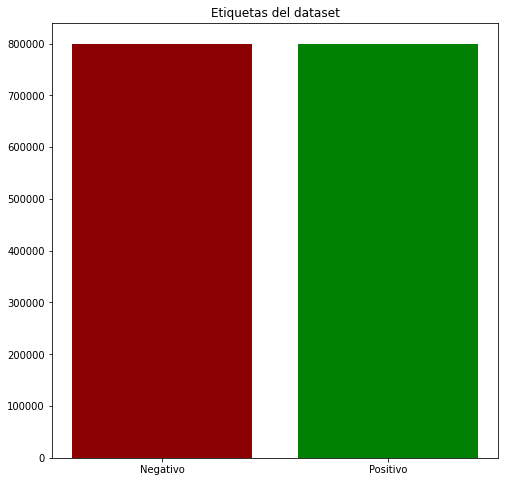

In [8]:
target_cnt = Counter(tweets.sentiment.astype("string"))
print(target_cnt.keys())
print(target_cnt.values())
plt.figure(figsize=(8, 8))
plt.bar(
    target_cnt.keys(),
    target_cnt.values(),
    tick_label=["Negativo", "Positivo"],
    color=["darkred", "green"],
)
plt.title("Etiquetas del dataset")

In [9]:
missing_values = tweets.isna().sum()
print(f"Missing values:\n\n{missing_values}")

Missing values:

index        0
sentiment    0
id           0
date         0
query        0
user         0
text         0
dtype: int64


Vemos que prácticamente las mitad de los tweets del dataset son negativos y la otra mitad son positivos. No aparece ninguno etiquetado directamente como neutro. En la mayoría de datasets esto también es así, aunque parezca paradójico, puede resultar más subjetivo clasificar a un tweet como neutral que como positivo o negativo. Se tratan de tweets escritos por personas, no de textos que puedan ser descriptivos. La solución más sencilla, es fijar unos umbrales a la hora de predecir nuevos valores. Si un tweet tiene una puntuación de positividad intermedia entre ambos, puede interpretarse que no queda muy claro si el tweets es positivo o negativo, y por lo tanto sería buena opción clasificarlo como neutro.

### Modelo de análisis de sentimiento

Utilizaremos un modelo de Deep Learning para clasificar nuestros tweets. Partimos de una colección de tweets etiquetados. Pese a que se ha tratado de normalizarlos y darles una homogeneidad, aún falta encontrar una forma de estudiar las asociaciones entre las palabras de cada uno de ellos, para poder almacenarlos de forma numérica y poder trabajar con ellos. Los pasos a seguir en la modelización serán los siguientes:
<ul>
    <li><b>Word2Vec:</b> Mediante técnicas de procesamiento de lenguaje natural, se usará una red neuroanl para estudiar las asocaciones entre las palabras de los textos. Una vez entrenado, el objetivo de este modelo será detectar sinónimos o sugerir palabras que presenten cierta relación a partir de una frase dada. De esta manera, tendremos nuestros tweets almacenados en vectores numéricos. </li>
    <li><b>Tokenization:</b> El siguiente paso será dividir cada uno de nuestros tweets en tokens. Nosotros partimos de una cadena dada, como por ejemplo ' Pfffdf hoy no me apetece nadar :( ', pues tenemos que dividir dicha sentencia en distintos tokens. Se habla de tokens y no de palabras puesto que no tienen por qué tener una léxica definida pero sí un significado semántico. Como bien puede ser palabras mal escritas ('Pfffdf' indica cansancio o desesperación) o conjuntos de caracteres (':(' indica tristeza).</li>
    <li><b>Label encoding:</b> Este paso es bien sencillo, simplemente necesitamos un codificador que nos sirva para convertir nuestras etiquetas a valores numéricos con los que podamos trabajar.</li>
    <li><b>Sentiment model:</b> Tras haber procesado nuestros datos de input, construiremos un primer modelo de red neuronal. Un modelo secuencial con una única capa oculta. Estudiaremos los resultados y veremos como podemos ir ajustando el modelo para mejorar nuestras predicciones.</li>
</ul>



Inicializamos el analizador de sentimientos.

In [10]:
sa = SentimentAnalyzer(tweets, "text", "sentiment",0,2,4)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\BISITE\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Si se desea entrenar un nuevo modelo y almacenar los resultados, se deben descomentar las tres líneas de código de abajo. Es un proceso bastante costoso, por lo que se pueden guardar y cargar modelos previamente entrenados. En este, cargaremos un conjunto de modelos ya entrenados previamente.

In [ ]:
sa.build_model()
sa.fit_model(batch_size = 128, epochs = 8)
sa.save_data("models")
#sa.load_data("models")

TRAIN size: 319888
TEST size: 1279552


2021-07-29 16:47:39,155 : INFO : Word2Vec lifecycle event {'params': 'Word2Vec(vocab=0, vector_size=300, alpha=0.025)', 'datetime': '2021-07-29T16:47:39.148591', 'gensim': '4.0.1', 'python': '3.8.10 (default, May 19 2021, 13:12:57) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19042-SP0', 'event': 'created'}
2021-07-29 16:47:39,155 : INFO : collecting all words and their counts
2021-07-29 16:47:39,156 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2021-07-29 16:47:39,179 : INFO : PROGRESS: at sentence #10000, processed 141010 words, keeping 31392 word types
2021-07-29 16:47:39,204 : INFO : PROGRESS: at sentence #20000, processed 281278 words, keeping 52629 word types
2021-07-29 16:47:39,230 : INFO : PROGRESS: at sentence #30000, processed 421005 words, keeping 71021 word types
2021-07-29 16:47:39,258 : INFO : PROGRESS: at sentence #40000, processed 562002 words, keeping 88076 word types
2021-07-29 16:47:39,282 : INFO : PROGRESS: at sentence #500

Vocab size 23602


2021-07-29 16:47:41,494 : INFO : EPOCH 1 - PROGRESS: at 51.49% examples, 1572649 words/s, in_qsize 15, out_qsize 0
2021-07-29 16:47:42,417 : INFO : worker thread finished; awaiting finish of 7 more threads
2021-07-29 16:47:42,420 : INFO : worker thread finished; awaiting finish of 6 more threads
2021-07-29 16:47:42,424 : INFO : worker thread finished; awaiting finish of 5 more threads
2021-07-29 16:47:42,429 : INFO : worker thread finished; awaiting finish of 4 more threads
2021-07-29 16:47:42,431 : INFO : worker thread finished; awaiting finish of 3 more threads
2021-07-29 16:47:42,432 : INFO : worker thread finished; awaiting finish of 2 more threads
2021-07-29 16:47:42,433 : INFO : worker thread finished; awaiting finish of 1 more threads
2021-07-29 16:47:42,436 : INFO : worker thread finished; awaiting finish of 0 more threads
2021-07-29 16:47:42,437 : INFO : EPOCH - 1 : training on 4511068 raw words (3068182 effective words) took 1.9s, 1576861 effective words/s
2021-07-29 16:47:43

2021-07-29 16:47:56,931 : INFO : worker thread finished; awaiting finish of 0 more threads
2021-07-29 16:47:56,931 : INFO : EPOCH - 8 : training on 4511068 raw words (3068272 effective words) took 1.9s, 1601656 effective words/s
2021-07-29 16:47:57,946 : INFO : EPOCH 9 - PROGRESS: at 54.36% examples, 1660992 words/s, in_qsize 15, out_qsize 0
2021-07-29 16:47:58,753 : INFO : worker thread finished; awaiting finish of 7 more threads
2021-07-29 16:47:58,754 : INFO : worker thread finished; awaiting finish of 6 more threads
2021-07-29 16:47:58,759 : INFO : worker thread finished; awaiting finish of 5 more threads
2021-07-29 16:47:58,760 : INFO : worker thread finished; awaiting finish of 4 more threads
2021-07-29 16:47:58,761 : INFO : worker thread finished; awaiting finish of 3 more threads
2021-07-29 16:47:58,768 : INFO : worker thread finished; awaiting finish of 2 more threads
2021-07-29 16:47:58,769 : INFO : worker thread finished; awaiting finish of 1 more threads
2021-07-29 16:47:58

2021-07-29 16:48:13,700 : INFO : worker thread finished; awaiting finish of 7 more threads
2021-07-29 16:48:13,701 : INFO : worker thread finished; awaiting finish of 6 more threads
2021-07-29 16:48:13,703 : INFO : worker thread finished; awaiting finish of 5 more threads
2021-07-29 16:48:13,704 : INFO : worker thread finished; awaiting finish of 4 more threads
2021-07-29 16:48:13,708 : INFO : worker thread finished; awaiting finish of 3 more threads
2021-07-29 16:48:13,710 : INFO : worker thread finished; awaiting finish of 2 more threads
2021-07-29 16:48:13,711 : INFO : worker thread finished; awaiting finish of 1 more threads
2021-07-29 16:48:13,711 : INFO : worker thread finished; awaiting finish of 0 more threads
2021-07-29 16:48:13,712 : INFO : EPOCH - 17 : training on 4511068 raw words (3068405 effective words) took 1.9s, 1637523 effective words/s
2021-07-29 16:48:14,727 : INFO : EPOCH 18 - PROGRESS: at 55.03% examples, 1680033 words/s, in_qsize 15, out_qsize 0
2021-07-29 16:48:

2021-07-29 16:48:28,660 : INFO : worker thread finished; awaiting finish of 3 more threads
2021-07-29 16:48:28,661 : INFO : worker thread finished; awaiting finish of 2 more threads
2021-07-29 16:48:28,665 : INFO : worker thread finished; awaiting finish of 1 more threads
2021-07-29 16:48:28,666 : INFO : worker thread finished; awaiting finish of 0 more threads
2021-07-29 16:48:28,666 : INFO : EPOCH - 25 : training on 4511068 raw words (3068167 effective words) took 1.8s, 1719405 effective words/s
2021-07-29 16:48:29,686 : INFO : EPOCH 26 - PROGRESS: at 52.37% examples, 1590553 words/s, in_qsize 15, out_qsize 0
2021-07-29 16:48:30,507 : INFO : worker thread finished; awaiting finish of 7 more threads
2021-07-29 16:48:30,512 : INFO : worker thread finished; awaiting finish of 6 more threads
2021-07-29 16:48:30,521 : INFO : worker thread finished; awaiting finish of 5 more threads
2021-07-29 16:48:30,522 : INFO : worker thread finished; awaiting finish of 4 more threads
2021-07-29 16:48:

Total words 258489
y_train (319888, 1)
y_test (1279552, 1)
x_train (319888, 300)
y_train (319888, 1)

x_test (1279552, 300)
y_test (1279552, 1)


2021-07-29 16:49:23,441 : WARNING : Layer lstm will not use cuDNN kernels since it doesn't meet the criteria. It will use a generic GPU kernel as fallback when running on GPU.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 300, 300)          77546700  
_________________________________________________________________
dropout (Dropout)            (None, 300, 300)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 100)               160400    
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 77,707,201
Trainable params: 160,501
Non-trainable params: 77,546,700
_________________________________________________________________
Epoch 1/8
2250/2250 [==============================] - 2715s 1s/step - loss: 0.5641 - acc: 0.7033 - val_loss: 0.4887 - val_acc: 0.7658
Epoch 2/8
 397/2250 [====>.........................] - ETA: 36:31 - loss: 0.5055 - acc: 0.7515

### Resultados del modelo

In [ ]:
sa.plot_confusion_matrix()

In [ ]:
sa.plot_confusion_table()

Podemos ver que para un primer modelo inicial, no está mal. Tenemos una capacidad predictora del 80% aproximadamente, también debido a que parte de ese 20% son tweets que tienen un score de positividad medio, y por tanto hemos clasificado como neutros, en lugar de clasificarlos simplemente como positivo o negativo. Fijándonos en la sensibilidad y la especificidad vemos que son también del 80%; es decir, tenemos la misma capacidad predictora tanto para tweets negativos como positivos.

### Predicciones

Finalmente, vamos a realizar una serie de predicciones para ver como se comporta nuestro modelo.

Cumplido a una persona. Esperamos que lo clasifique como positivo.

In [ ]:
sa.predict("Qué genial es tu sombrero")

Mensaje de odio hacia una persona. Esperamos que lo clasifique como negativo.

In [ ]:
sa.predict("Que pesado es, no lo soporto")

Mensaje descriptivo, sin entrar en valoraciones. Esperamos que lo clasifique como neutro.

In [ ]:
sa.predict("simplemente es así, sin más")